## 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme()

## 2. Load and Preview Dataset

I am using a baseball dataset of pitchers from the 2025 MLB season (through June 14), containing both traditional counting stats (ERA, SLG, BA) and expected stats (xERA, xSLG, xBA). Data was collected by Major League Baseball and made publicly available on Baseball Savant leaderboards. I chose not to establish a minimum for qualification; rather than selecting all qualified pitchers, I selected all pitchers with at least one batter faced in 2025. 


In [2]:
df = pd.read_csv('linear_regression_data.csv')
df.head(20)


,"last_name, first_name",player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,era,xera,era_minus_xera_diff
0,"Severino, Luis",622663,2025,361,269,0.256,0.285,-0.029,0.377,0.425,-0.048,0.309,0.337,-0.028,4.77,4.34,0.431
1,"Valdez, Framber",664285,2025,359,231,0.216,0.245,-0.029,0.336,0.388,-0.052,0.278,0.310,-0.032,3.10,3.60,-0.500
2,"Schwellenbach, Spencer",680885,2025,358,258,0.225,0.267,-0.042,0.373,0.412,-0.039,0.273,0.307,-0.034,3.11,3.53,-0.418
3,"Webb, Logan",657277,2025,355,235,0.252,0.243,0.009,0.354,0.345,0.009,0.284,0.276,0.008,2.58,2.82,-0.244
4,"Irvin, Jake",663623,2025,352,271,0.243,0.284,-0.041,0.422,0.528,-0.106,0.317,0.370,-0.053,4.21,5.39,-1.178
5,"Crochet, Garrett",676979,2025,352,214,0.207,0.218,-0.011,0.313,0.359,-0.046,0.261,0.283,-0.022,2.35,2.97,-0.618
6,"Keller, Mitch",656605,2025,350,261,0.261,0.272,-0.011,0.380,0.412,-0.032,0.307,0.321,-0.014,4.15,3.89,0.264
7,"Littell, Zack",641793,2025,347,273,0.258,0.272,-0.014,0.492,0.513,-0.021,0.335,0.347,-0.012,3.84,4.64,-0.798
8,"Bassitt, Chris",605135,2025,346,245,0.267,0.253,0.014,0.410,0.408,0.002,0.319,0.309,0.010,3.70,3.58,0.117
9,"Fried, Max",608331,2025,346,243,0.198,0.241,-0.043,0.297,0.393,-0.096,0.245,0.298,-0.053,1.84,3.31,-1.469


## 3. Data Cleaning and Filtering

Now, I do want to set a minimum for pitcher eligibility. I have filtered the data to include only pitchers with at least 162 plate appearances, ensuring statistical stability. This is MLB's standard threshold for qualification as it equals 1 plate appearance per game. I also use this to confirm there is no missing data. 

In [3]:
refined_df = df[df['pa'] >= 162].copy()

assert refined_df.isna().sum().sum() == 0, "Missing data found"
assert refined_df.duplicated(subset=['player_id']).sum() == 0, "Duplicate players found"

print(f"Filtered dataset has {len(refined_df)} pitchers.")

Filtered dataset has 153 pitchers.


## 4. Exploratory Data Analysis

I use this section to examine distributions and relationships between key stats. This allows me to explore the data further and pick up on any potential trends or relationships that may be present. 

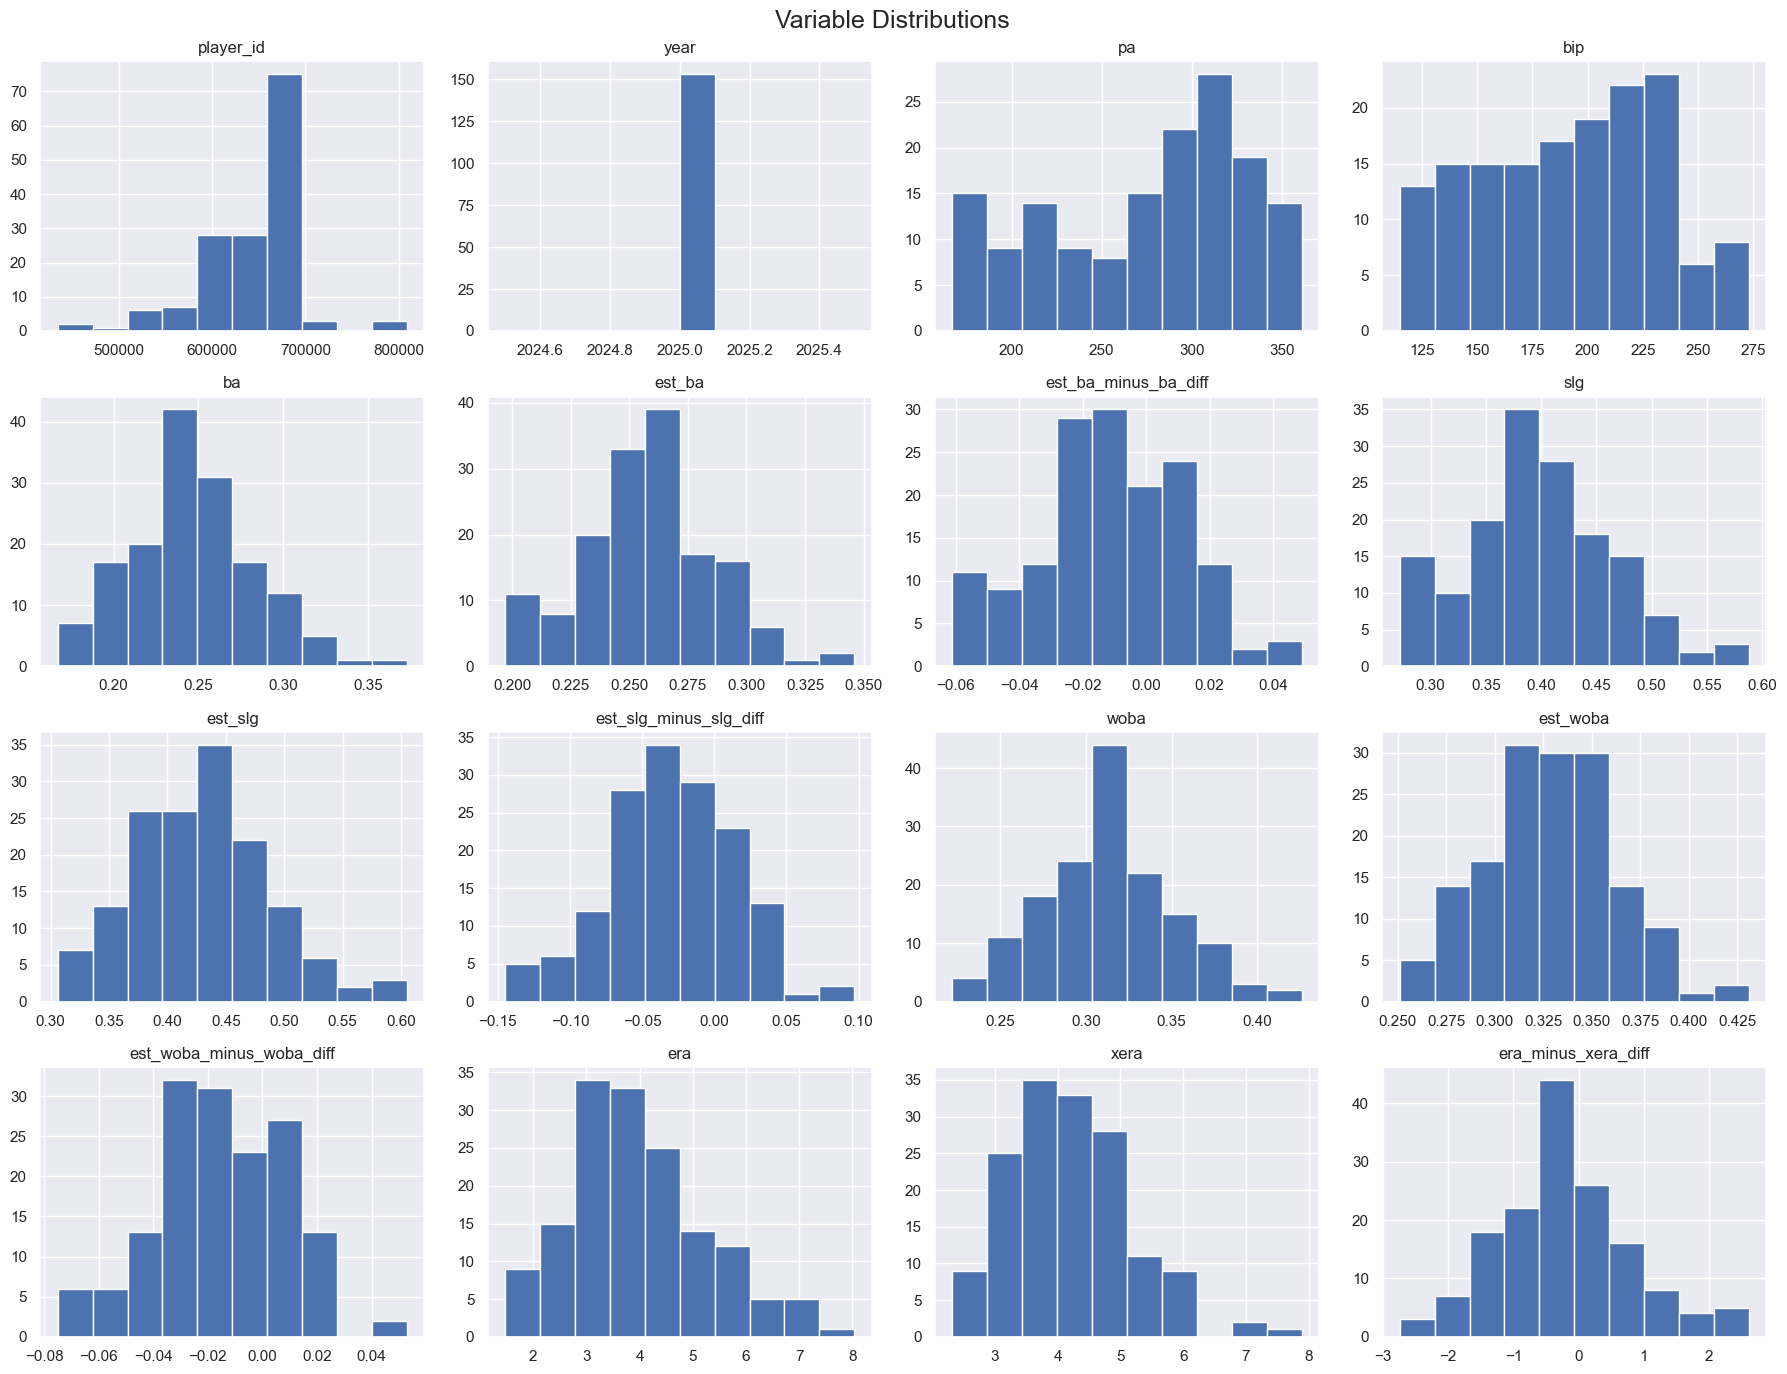

In [4]:
# Histogram of all numeric variables
refined_df.hist(figsize=(18, 14))
plt.suptitle('Variable Distributions', fontsize=18)
plt.tight_layout()
plt.show()

#make histograms of each variable to check for normal distribution
#the goal is to compare a counting stat with an expected stat, if possible

After creating histograms for each variable, it is determined that several variables do follow a normal distribution. Importantly, some of these variables are baseball counting stats, while others are expected stats. This should allow us to proceed with the linear regression.

Additionally, there do not appear to be any major outliers present. The player_id variable does have an apparent outlier, but that is ok because they are merely identifying numbers assigned to players, and not numerical variables such as a player statistic. 

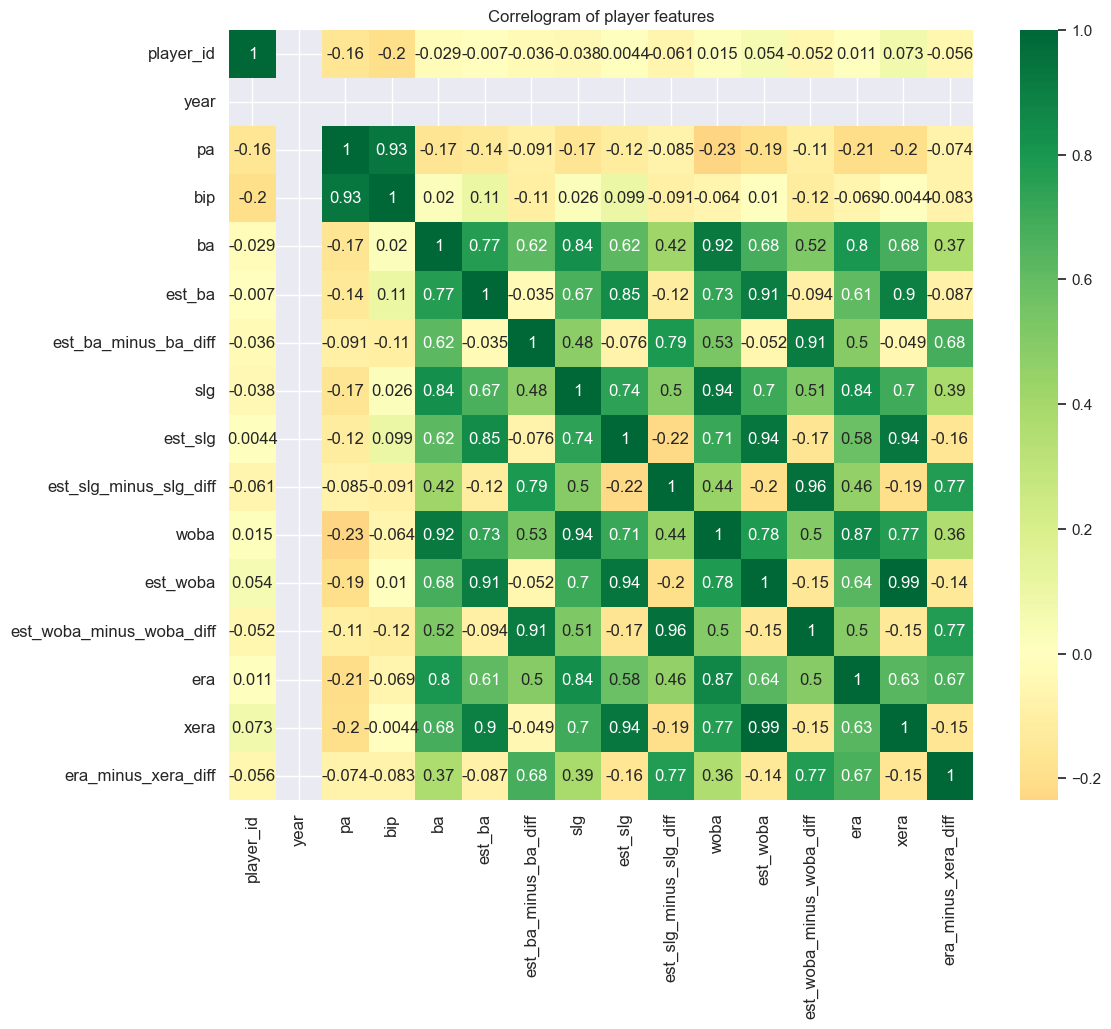

In [5]:
# Correlogram
corr = refined_df.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn', center=0, annot=True)

plt.yticks(fontsize=12)
plt.title('Correlogram of player features')
plt.xticks(fontsize=12)
plt.show()

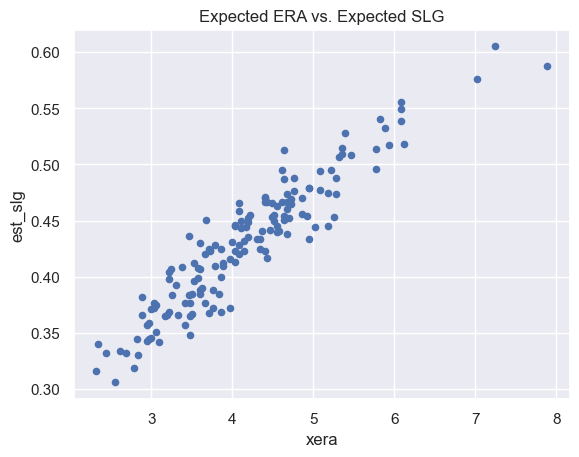

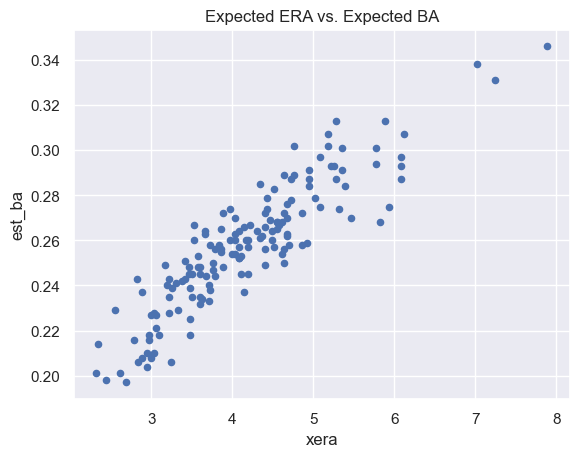

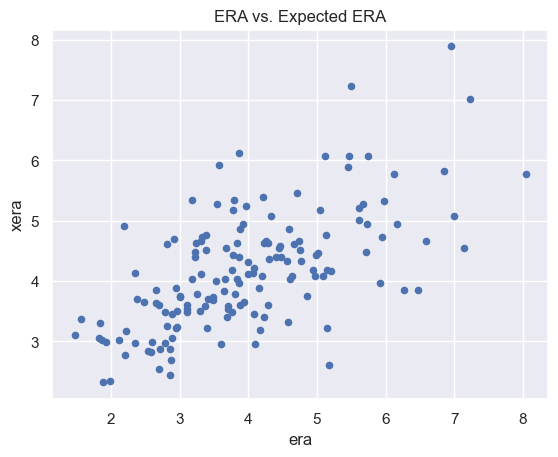

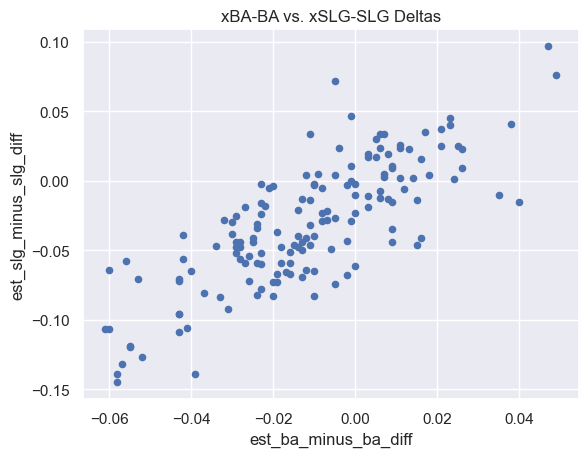

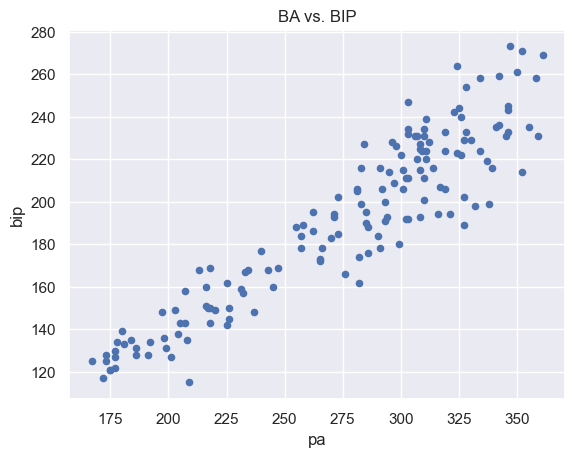

In [6]:
# Example scatterplots
refined_df.plot(kind='scatter', x='xera', y='est_slg', title="Expected ERA vs. Expected SLG")
plt.show()

refined_df.plot(kind='scatter', x='xera', y='est_ba', title="Expected ERA vs. Expected BA")
plt.show()

refined_df.plot(kind='scatter', x='era', y='xera', title="ERA vs. Expected ERA")
plt.show()

refined_df.plot(kind='scatter', x='est_ba_minus_ba_diff', y='est_slg_minus_slg_diff',
                title="xBA-BA vs. xSLG-SLG Deltas")
plt.show()

refined_df.plot(kind='scatter', x='pa', y='bip', title="BA vs. BIP")
plt.show()

## 5. Linear Regression: Predicting Expected SLG from xERA

I will now build a linear regression model using expected ERA (`xera`) to predict expected slugging percentage (`est_slg`).

In [7]:
# Define variables
X = refined_df[['xera']]
y = refined_df['est_slg']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
# Train model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_pred = linreg.predict(X_test)

# Evaluation
train_r2 = linreg.score(X_train, y_train)
test_r2 = linreg.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Train R2: {train_r2:.3f}")
print(f"Test R2: {test_r2:.3f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Intercept: {linreg.intercept_:.4f}")
print(f"Coefficient: {linreg.coef_[0]:.4f}")

Train R2: 0.885
Test R2: 0.784
Test RMSE: 0.0230
Intercept: 0.1961
Coefficient: 0.0562


## 6. Best-Fit Linear Regression Line

Next I overlaid the regression line on the training data to evalaute the linear fit.


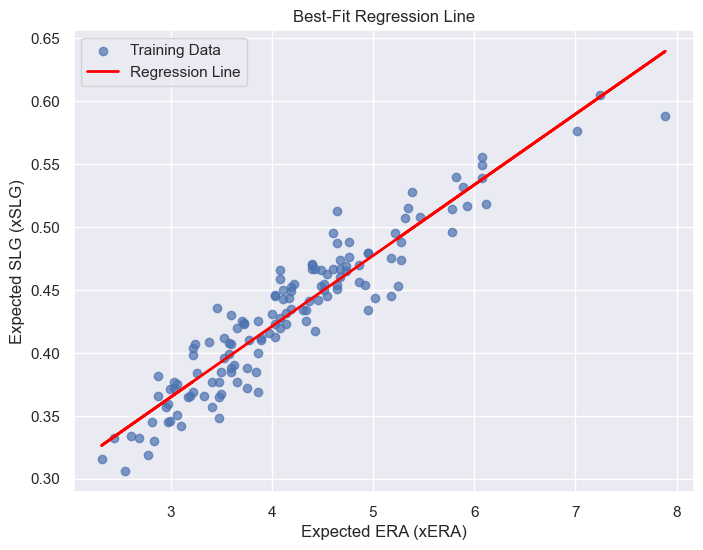

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, alpha=0.7, label="Training Data")
plt.plot(X_train, linreg.predict(X_train), color='red', linewidth=2, label="Regression Line")
plt.xlabel("Expected ERA (xERA)")
plt.ylabel("Expected SLG (xSLG)")
plt.title("Best-Fit Regression Line")
plt.legend()
plt.grid(True)
plt.show()


## 7. Residuals

Now, I examine the residuals (actual minus predicted values) to evaluate assumptions such as normality and constant variance.

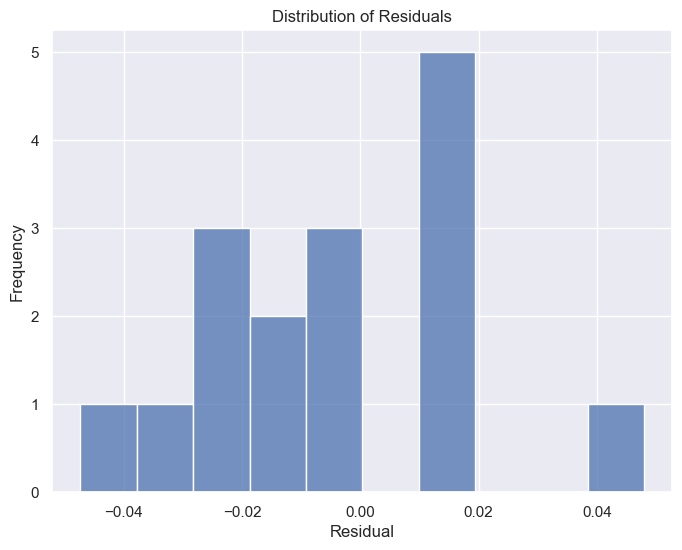

In [9]:
# calculate residuals
residuals = y_test - y_pred

# Plot distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=10)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

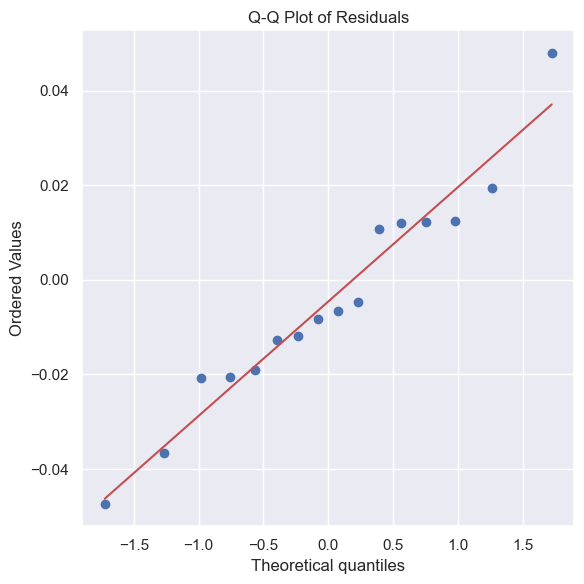

In [11]:
import scipy.stats as stats
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

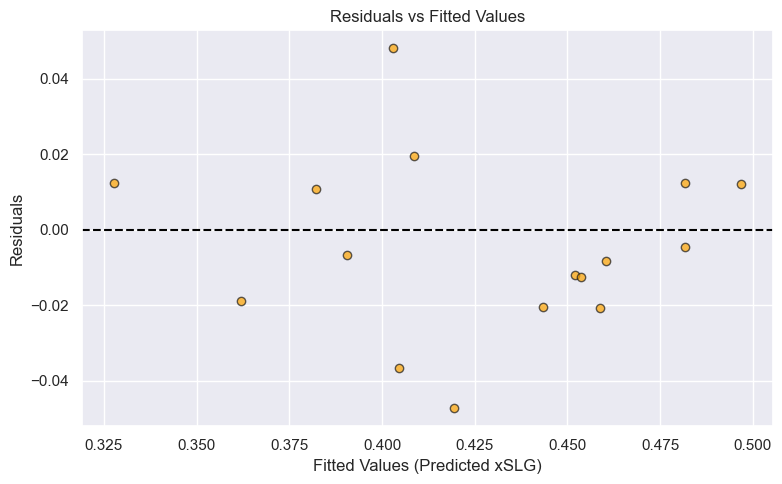

In [15]:
# Residuals vs Fitted Values Plot
test_preds = y_pred  

plt.figure(figsize=(8, 5))
plt.scatter(test_preds, residuals, alpha=0.7, edgecolor='k', color='orange')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Fitted Values (Predicted xSLG)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(True)
plt.tight_layout()
plt.show()
